In [ ]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

from grnndata import read_h5ad
import numpy as np
import tqdm
import os

#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc

from scprint import scPrint
from scprint.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
import scanpy as sc
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import scipy.sparse

from scdataloader.utils import load_genes
import anndata as ad
import bionty as bt
from grnndata import from_adata_and_longform

import torch

torch.set_float32_matmul_precision("medium")

%load_ext autoreload
%autoreload 2

LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data"  #

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/ctxcore/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


# J comparison of gene networks from human interactome, cellmaps, omnipath,


In [1]:
! wget --no-check-certificate -O $LOC/RF2-PPI.gz https://conglab.swmed.edu/humanPPI/downloads/RF2-PPI_scores.gz
! wget --no-check-certificate -O $LOC/DCA_scores.gz https://conglab.swmed.edu/humanPPI/downloads/DCA_scores.gz

--2025-11-12 23:10:51--  https://conglab.swmed.edu/humanPPI/downloads/RF2-PPI_scores.gz


Resolving maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)... 192.168.148.66
Connecting to maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)|192.168.148.66|:3128... connected.


Proxy request sent, awaiting response... 

200 OK
Length: 443540479 (423M) [application/x-gzip]
Saving to: ‘/pasteur/appa/scratch/jkalfon/data/spcrint_data/RF2-PPI.gz’


          /pasteur/   0%[                    ]       0  --.-KB/s               


         /pasteur/a   0%[                    ]  46.78K   191KB/s               


        /pasteur/ap   0%[                    ] 210.84K   431KB/s               


       /pasteur/app   0%[                    ] 867.09K  1.15MB/s               


      /pasteur/appa   0%[                    ]   3.42M  3.50MB/s               


     /pasteur/appa/   2%[                    ]   9.36M  7.90MB/s               


    /pasteur/appa/s   3%[                    ]  15.29M  11.0MB/s               


   /pasteur/appa/sc   4%[                    ]  18.32M  11.5MB/s               


  /pasteur/appa/scr   5%[>                   ]  24.16M  13.1MB/s               


 /pasteur/appa/scra   7%[>                   ]  30.14M  14.4MB/s               


/pasteur/appa/scrat   8%[>                   ]  35.99M  15.4MB/s               


pasteur/appa/scratc   9%[>                   ]  41.93M  16.2MB/s               


asteur/appa/scratch  11%[=>                  ]  47.77M  16.8MB/s               


steur/appa/scratch/  12%[=>                  ]  53.69M  17.4MB/s    eta 21s    


teur/appa/scratch/j  14%[=>                  ]  59.55M  17.9MB/s    eta 21s    


eur/appa/scratch/jk  15%[==>                 ]  65.41M  18.3MB/s    eta 21s    


ur/appa/scratch/jka  16%[==>                 ]  71.32M  18.6MB/s    eta 21s    


r/appa/scratch/jkal  18%[==>                 ]  77.24M  20.1MB/s    eta 18s    


/appa/scratch/jkalf  19%[==>                 ]  83.17M  22.4MB/s    eta 18s    


appa/scratch/jkalfo  21%[===>                ]  89.04M  23.5MB/s    eta 18s    


ppa/scratch/jkalfon  22%[===>                ]  94.95M  23.3MB/s    eta 18s    


pa/scratch/jkalfon/  23%[===>                ] 100.78M  23.8MB/s    eta 16s    


a/scratch/jkalfon/d  25%[====>               ] 106.76M  23.4MB/s    eta 16s    


/scratch/jkalfon/da  26%[====>               ] 112.53M  23.8MB/s    eta 16s    


scratch/jkalfon/dat  28%[====>               ] 118.48M  23.8MB/s    eta 16s    


cratch/jkalfon/data  29%[====>               ] 124.30M  23.4MB/s    eta 15s    


ratch/jkalfon/data/  30%[=====>              ] 130.28M  23.8MB/s    eta 15s    


atch/jkalfon/data/s  32%[=====>              ] 136.09M  23.8MB/s    eta 15s    


tch/jkalfon/data/sp  33%[=====>              ] 142.06M  23.4MB/s    eta 15s    


ch/jkalfon/data/spc  34%[=====>              ] 147.93M  23.8MB/s    eta 13s    


h/jkalfon/data/spcr  36%[======>             ] 153.88M  23.8MB/s    eta 13s    


/jkalfon/data/spcri  37%[======>             ] 159.74M  23.4MB/s    eta 13s    


jkalfon/data/spcrin  39%[======>             ] 165.66M  23.8MB/s    eta 13s    


kalfon/data/spcrint  40%[=======>            ] 171.46M  23.7MB/s    eta 12s    


alfon/data/spcrint_  41%[=======>            ] 177.44M  23.4MB/s    eta 12s    


lfon/data/spcrint_d  43%[=======>            ] 183.22M  23.8MB/s    eta 12s    


fon/data/spcrint_da  44%[=======>            ] 189.20M  23.8MB/s    eta 12s    


on/data/spcrint_dat  46%[========>           ] 194.98M  23.4MB/s    eta 11s    


n/data/spcrint_data  47%[========>           ] 200.95M  23.3MB/s    eta 11s    


/data/spcrint_data/  48%[========>           ] 206.79M  23.7MB/s    eta 11s    


data/spcrint_data/R  50%[=========>          ] 212.41M  23.3MB/s    eta 11s    


ata/spcrint_data/RF  51%[=========>          ] 218.34M  23.3MB/s    eta 11s    


ta/spcrint_data/RF2  52%[=========>          ] 224.17M  23.7MB/s    eta 9s     


a/spcrint_data/RF2-  54%[=========>          ] 230.16M  23.7MB/s    eta 9s     


/spcrint_data/RF2-P  55%[==========>         ] 236.11M  23.3MB/s    eta 9s     


spcrint_data/RF2-PP  57%[==========>         ] 241.96M  23.7MB/s    eta 9s     


pcrint_data/RF2-PPI  58%[==========>         ] 247.92M  23.7MB/s    eta 8s     


crint_data/RF2-PPI.  59%[==========>         ] 253.76M  23.3MB/s    eta 8s     


rint_data/RF2-PPI.g  61%[===========>        ] 259.72M  23.4MB/s    eta 8s     


int_data/RF2-PPI.gz  62%[===========>        ] 265.58M  23.8MB/s    eta 8s     


nt_data/RF2-PPI.gz   64%[===========>        ] 271.47M  23.3MB/s    eta 7s     


t_data/RF2-PPI.gz    65%[============>       ] 277.34M  23.3MB/s    eta 7s     


_data/RF2-PPI.gz     66%[============>       ] 283.25M  23.4MB/s    eta 7s     


data/RF2-PPI.gz      68%[============>       ] 289.12M  23.7MB/s    eta 7s     


ata/RF2-PPI.gz       69%[============>       ] 295.00M  23.8MB/s    eta 6s     


ta/RF2-PPI.gz        71%[=============>      ] 300.95M  23.4MB/s    eta 6s     


a/RF2-PPI.gz         72%[=============>      ] 306.82M  23.5MB/s    eta 6s     


/RF2-PPI.gz          73%[=============>      ] 312.76M  23.3MB/s    eta 6s     


RF2-PPI.gz           75%[==============>     ] 318.64M  23.8MB/s    eta 5s     


F2-PPI.gz            76%[==============>     ] 324.51M  23.8MB/s    eta 5s     


2-PPI.gz             78%[==============>     ] 330.41M  23.3MB/s    eta 5s     


-PPI.gz              79%[==============>     ] 336.30M  23.4MB/s    eta 5s     


PPI.gz               80%[===============>    ] 342.24M  23.3MB/s    eta 4s     


PI.gz                82%[===============>    ] 348.14M  23.8MB/s    eta 4s     


I.gz                 83%[===============>    ] 354.07M  23.4MB/s    eta 4s     


.gz                  85%[================>   ] 359.92M  23.3MB/s    eta 4s     


gz                   86%[================>   ] 365.86M  23.8MB/s    eta 3s     


z                    87%[================>   ] 371.69M  23.4MB/s    eta 3s     


                     89%[================>   ] 377.65M  23.4MB/s    eta 3s     


                  /  90%[=================>  ] 383.42M  23.8MB/s    eta 3s     


                 /p  92%[=================>  ] 389.35M  24.1MB/s    eta 3s     


                /pa  93%[=================>  ] 394.23M  23.7MB/s    eta 1s     


               /pas  94%[=================>  ] 398.15M  23.4MB/s    eta 1s     


              /past  95%[==================> ] 404.01M  23.8MB/s    eta 1s     

In [ ]:
res = pd.read_csv(
    LOC + "/RF2-PPI.gz",
    sep="\t",
    skiprows=7,
    header=None,  # nrows=100_000_000
)
res.columns = ["Pair", "RF2-PPI_interaction_probability", "Source"]

In [ ]:
import bionty as bt

In [ ]:
sns.histplot(res["RF2-PPI_interaction_probability"])

In [ ]:
prot_to_gene = {
    i["uniprotkb_id"]: i["gene_symbol"] for k, i in bt.Protein.public().df().iterrows()
}
genes = []
for i in res.Pair:
    a, b = i.split("_")
    genes.append([prot_to_gene.get(a, ""), prot_to_gene.get(b, "")])

res[["geneA", "geneB"]] = genes

In [ ]:
res = res[~res["geneA"].isna() & ~res["geneB"].isna()]

In [ ]:
res.to_parquet(LOC + "/RF2-PPI.parquet")

In [ ]:
res = pd.read_parquet(LOC + "/RF2-PPI.parquet")

In [3]:
THRESHOLD = 0.4

In [ ]:
humaninter_s = set(
    res[res["RF2-PPI_interaction_probability"] > THRESHOLD]["geneA"]
    .str.cat(res[res["RF2-PPI_interaction_probability"] > THRESHOLD]["geneB"], sep="_")
    .tolist()
)

In [5]:
len(humaninter_s)

765411

In [6]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name
gwps = gwps.extract_links()

In [7]:
omni = get_GT_db("omnipath")
collectri = get_GT_db("collectri")

In [8]:
omni_s = set([s + "_" + t for s, t in omni.iloc[:, :2].values])
collectri_s = set([s + "_" + t for s, t in collectri.iloc[:, :2].values])
gwps_s = set([s + "_" + t for s, t in gwps.iloc[:, :2].values])

In [9]:
# getting U2OS cell map data
import json

try:
    import ndex2
except ImportError:
    os.system("uv pip install ndex2")
    import ndex2
from ndex2.cx2 import RawCX2NetworkFactory, CX2NetworkXFactory
from ndex2.cx2 import CX2NetworkPandasDataFrameFactory

# Create NDEx2 python client
client = ndex2.client.Ndex2()

# Create CX2Network factory
factory = RawCX2NetworkFactory()

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
# https://www.ndexbio.org/viewer/networks/669f30a3-cee6-11ea-aaef-0ac135e8bacf
client_resp = client.get_network_as_cx2_stream("95bc75d5-d1d1-11ee-8a40-005056ae23aa")

# Convert downloaded network to CX2Network object
net_cx = factory.get_cx2network(json.loads(client_resp.content))

# Display information about network and output 1st 100 characters of CX2
print("Name: " + net_cx.get_name())
print("Number of nodes: " + str(len(net_cx.get_nodes())))
print("Number of nodes: " + str(len(net_cx.get_edges())))

# Creating an instance of CX2NetworkPandasDataFrameFactory
factory = CX2NetworkPandasDataFrameFactory()

# Converting CX2Network to DataFrame
cellmap = factory.get_dataframe(net_cx)

Name: U2OS AP-MS network
Number of nodes: 7543
Number of nodes: 36842


In [10]:
cellmap_s = set([s + "_" + t for s, t in cellmap.iloc[:, [2, 4]].values])

In [11]:
print("number of edges in gwps: ", len(gwps_s))
print("number of edges in omni: ", len(omni_s))
print("number of edges in collectri: ", len(collectri_s))
print("number of edges in humaninter: ", len(humaninter_s))
print("number of edges in cellmap: ", len(cellmap_s))

number of edges in gwps:  1115036
number of edges in omni:  273556
number of edges in collectri:  41595
number of edges in humaninter:  765411
number of edges in cellmap:  36842


In [14]:
cellmap_s

{'ASPH_SLC38A1',
 'NEMP1_GLRB',
 'WASHC3_ATP6V0D1',
 'EFNB2_USP32',
 'ERAP1_UBTF',
 'ZFPL1_RAB3GAP1',
 'SPINT2_OSMR',
 'VENTX_PON2',
 'VENTX_PGLS',
 'CLGN_JMJD8',
 'FGL1_LIMCH1',
 'ZNF346_YTHDC1',
 'CHRM4_SLC25A24',
 'CD40_SMG8',
 'LPAR1_ACSL4',
 'CTSV_LRRC15',
 'LRRC49_SANBR',
 'MRPS23_GYS1',
 'PTPN4_SVIL',
 'NEUROG3_RBM23',
 'VENTX_PPCS',
 'FOSL2_C1D',
 'BBS1_BBS5',
 'SNAP91_BRCA1',
 'CDC20_SKP2',
 'TMEM31_UCHL5',
 'PYCR3_BCL7C',
 'ITM2C_CYRIB',
 'NIPAL1_TRPM4',
 'HTR2C_TBC1D15',
 'TTC9C_USO1',
 'GAB2_PLS3',
 'BRK1_ABI3',
 'SPSB2_USP11',
 'ANKRD46_ATRN',
 'EGFL8_EGFL7',
 'SURF6_SCAF8',
 'UCHL5_INO80C',
 'MED17_MED9',
 'PSG3_TMEM214',
 'FBXO6_IGF1R',
 'IGF2BP3_MRPL10',
 'CTSV_CTSL',
 'RBMX2_SPOUT1',
 'CCT7_TXNDC9',
 'CTNNBIP1_CTNNA2',
 'LPAR1_EXOC6B',
 'NDUFC2_NDUFB1',
 'GPR12_ATL3',
 'TLE2_CCT5',
 'CCT7_KLHDC8B',
 'S1PR3_NIBAN2',
 'GPR17_ECHDC1',
 'PSMA5_PSMB7',
 'PLOD3_VPS33B',
 'YWHAB_RAI14',
 'LPAR1_SKP2',
 'ANAPC5_CDC27',
 'ACVR1_MED24',
 'KCTD17_EGFL7',
 'SLC2A12_ACY1',
 'FOSL2_

In [13]:
gwps_s

{'CAD_TAF2',
 'ZNF670_KRR1',
 'TCEA1_PMPCA',
 'PPP1R12A_CNOT9',
 'KDM6A_MED19',
 'RBM14_ERCC2',
 'KIF5B_RPS27',
 'ERP44_MED29',
 'NUP155_GRPEL1',
 'RPLP1_ESYT1',
 'RPS19_HSPD1',
 'SESN2_NELFE',
 'MEF2C_WDR61',
 'SNHG32_ZNRD1',
 'MICOS10_CCT7',
 'RPL35A_POP5',
 'PRELID1_PPIH',
 'IER3IP1_INTS7',
 'CD53_UHRF1',
 'SLC25A5_NUP54',
 'ANKRD28_SETX',
 'FBL_INTS2',
 'GNL3L_GPS1',
 'PRPF8_CCDC6',
 'RPS23_DIS3',
 'PRDX1_RUVBL1',
 'CTAG2_PRKCA',
 'ANKRD11_VARS',
 'ZDHHC3_ADSL',
 'TPR_TYK2',
 'TMEM147_TBL3',
 'RPLP0_DDX3X',
 'ATXN7L3B_RIOK2',
 'NORAD_GPS1',
 'EEF2_GFER',
 'UBE2H_DDX24',
 'RPS6_TNIP1',
 'PYURF_NUP133',
 'CKS1B_TAF1C',
 'C1orf35_RPL36',
 'TIMMDC1_ADAL',
 'EXPH5_PTPN1',
 'PFDN5_NOP16',
 'FAM49B_VPS29',
 'POLR1D_PMPCB',
 'C11orf58_MED22',
 'MRPL51_TTC4',
 'CNOT10_ITGB1BP1',
 'SRP19_RRS1',
 'MARCKSL1_DOHH',
 'MFAP1_WDR76',
 'RHOC_DNAJC19',
 'SEC61G_POLR2B',
 'F11R_ZDHHC7',
 'TXNRD2_MAX',
 'RPL32_UBE3D',
 'TPM4_SMC1A',
 'RPL10A_LUC7L3',
 'FAM49B_MAX',
 'ACAA1_RPTOR',
 'HMGN2_INTS2',
 'MT

In [12]:
humaninter_s

{'RB1CC1_MARCHF2',
 'SLC7A13_B3GALT1',
 'PDHA1_PDHB',
 'ALG10B_TMEM69',
 'CD2BP2_STK40',
 'IGHV2-70_IGKV1-13',
 'UNC5C_TMEM138',
 'HNRNPA0_ZNF580',
 'EPHA4_FRZB',
 'REXO1L1P_ANKRD52',
 'GNMT_DOHH',
 'CCNA1_CWC27',
 'OR4A8_PCDHGC4',
 'RP2_RUSF1',
 'KNOP1_POLDIP3',
 'MCU_MYO5C',
 'GOLGA2_PTK7',
 'YWHAB_KCNK4',
 'IGLV3-25_IGHV3-53',
 'SNRPGP15_CUL4A',
 'TLR2_DOHH',
 'BHLHA15_ASCL3',
 'OR2A42_HACD3',
 'DEF8_LRIG1',
 'TAF11L2_CDK9',
 'WDR77_SCML2',
 'CIAO1_TWF2',
 'RABGGTB_GMFB',
 'AKR7A3_CCT5',
 'SSU72L5_STK17B',
 'LRG1_RCN1',
 'PARD6G_EIF2B3',
 'SUPV3L1_DPH7',
 'FNIP1_SLC38A7',
 'RPL3_DDX25',
 'MYO1B_PPIL3',
 'SDCBP2_NOC2L',
 'PRP4K_ANGEL2',
 'DTYMK_ADRA1B',
 'TMEM198_LRTM2',
 'BPGM_RPH3A',
 'STK11_PRMT6',
 'CFHR3_FCN2',
 'COX10_TMEM201',
 'DGKE_SVIP',
 'CXorf66_TMEM123',
 'CLUAP1_CEP19',
 'SMN1; SMN2_ISG20',
 'SAMD5_ELMOD2',
 'RNF4_NGB',
 'OR51D1_OR1L6',
 'MT-CO2_ANKIB1',
 'PHYHD1_TMEM186',
 'MORN5_ADGRE2',
 'KDM1A_SCRT1',
 'TTC36_TPST2',
 'MIXL1_RBM8A',
 'EVPLL_DPEP2',
 'TM7SF2_AADAC',


In [ ]:
! uv pip install venn

<Axes: >

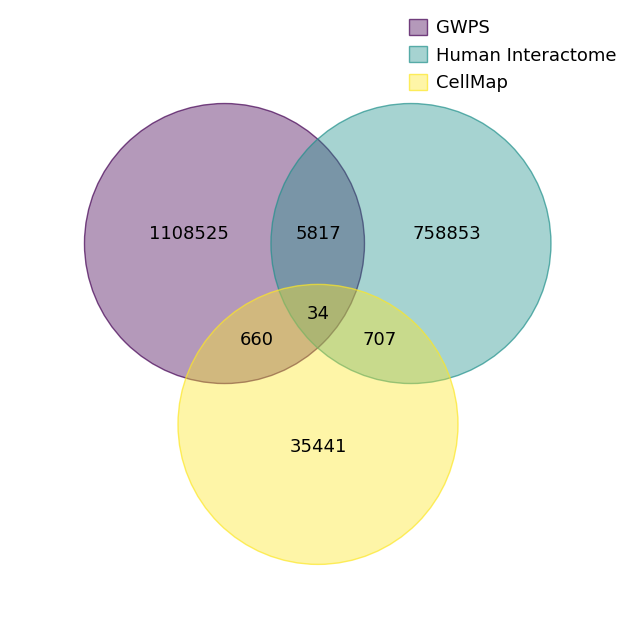

In [15]:
from venn import venn

# Create a dictionary of sets
sets = {
    #'OmniPath': omni,
    #'CollecTRI': collectri,
    "GWPS": gwps_s,
    "Human Interactome": humaninter_s,
    "CellMap": cellmap_s,
}

venn(sets)

In [15]:
sets = {
    "OmniPath": omni_s,
    "CollecTRI": collectri_s,
    "GWPS": gwps_s,
    "Human Interactome": humaninter_s,
    "CellMap": cellmap_s,
}

venn(sets)

NameError: name 'omni_s' is not defined

<Axes: >

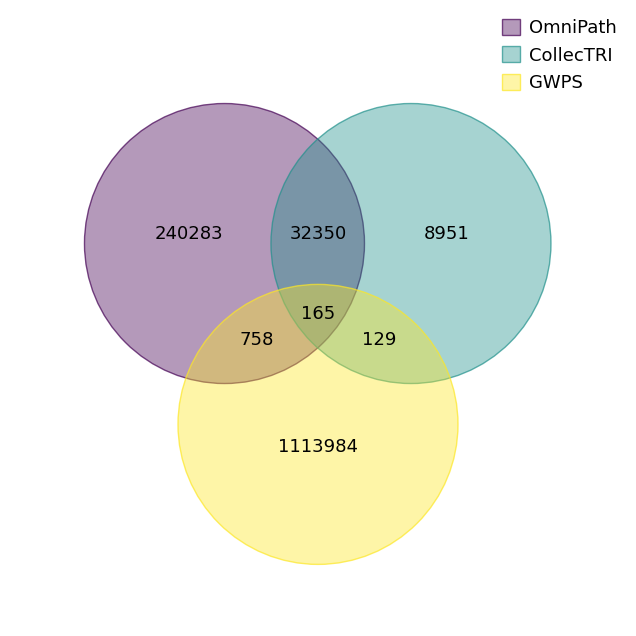

In [ ]:
sets = {
    "OmniPath": omni_s,
    "CollecTRI": collectri_s,
    "GWPS": gwps_s,
    #'Human Interactome': humaninter,
    #'CellMap': cellmap
}

venn(sets)

In [ ]:
del res

## predict human interactome network


In [1]:
model_checkpoint_file = "../models/ji9krimq.ckpt"  # w937u4o1.ckpt"

In [2]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [ ]:
# Load gene names
genes = load_genes("NCBITaxon:9606")

# Create empty anndata with gene names
empty_adata = ad.AnnData(X=np.zeros((1, len(genes))), var=genes)
print(f"Created empty AnnData with {len(genes)} genes")
empty_adata.var["ensembl_id"] = empty_adata.var.index
empty_adata.var.set_index("symbol", inplace=True, drop=False)
gt_cm = from_adata_and_longform(empty_adata, cellmap.iloc[:, [2, 4]])
gt_cm = gt_cm[:, (gt_cm.varp["GRN"].sum(1) != 0) | (gt_cm.varp["GRN"].sum(0) != 0)]
gt_cm.varp["GRN"] = scipy.sparse.csr_matrix(gt_cm.varp["GRN"].astype(np.float32))
gt_cm.varp["GRN"] = scipy.sparse.csr_matrix(gt_cm.varp["GRN"].astype(np.float32))

gt_inter = from_adata_and_longform(
    empty_adata,
    res[res["RF2-PPI_interaction_probability"] > THRESHOLD][
        ["geneA", "geneB", "RF2-PPI_interaction_probability"]
    ],
    has_weight=True,
)


gt_cm.var.index.name = "index"
gt_inter.var.index.name = "index"

In [ ]:
gt_cm.write_h5ad(LOC + "/gt_cellmap.h5ad")
gt_inter.write_h5ad(LOC + "/gt_humaninter.h5ad")

In [3]:
gt_cm = read_h5ad(LOC + "/gt_cellmap.h5ad")
gt_inter = read_h5ad(LOC + "/gt_humaninter.h5ad")

In [4]:
# only dataset dropped
adata = sc.read(
    LOC + "/glio_smart_highdepth" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

adata.var["isTF"] = False
adata.var.loc[adata.var.feature_name.isin(grnutils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 3589 × 22149
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered'

In [5]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata)

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 3589 renamining
filtered out 22 cells, 3567 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 47967 genes in the ontology but not present in the dataset
starting QC
Seeing 71 outliers (1.99% of total dataset):
done
AnnData object with n_obs × n_vars = 3567 × 70116
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_

In [6]:
adata = adata[(adata.X.sum(1) > 500)]
adata.obs.cell_type.value_counts()

cell_type
myeloid cell                      1841
neoplastic cell                   1077
oligodendrocyte precursor cell     405
astrocyte                           88
oligodendrocyte                     81
vascular lymphangioblast            49
neuron                              21
Name: count, dtype: int64

In [7]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name

In [8]:
gt_inter_high_qual = gt_inter.copy()
gt_inter_high_qual.varp["GRN"] = (gt_inter_high_qual.varp["GRN"] > 0.7).astype(
    np.float32
)

In [17]:
model.mask_zeros = True

In [ ]:
metrics = {}
shapes = []
for celltype in adata.obs.cell_type.value_counts().keys().tolist():
    grn_inferer = GNInfer(
        how="most var across",  # most expr
        preprocess="softmax",
        head_agg="mean",
        filtration="none",
        num_genes=4000,
        max_cells=256,
        num_workers=8,
        batch_size=16,
        precomp_attn=True,
    )
    grn = grn_inferer(model, adata, cell_type=celltype)
    grn.var.index = make_index_unique(grn.var["symbol"].astype(str))
    grn.varp["GRN"][np.isnan(grn.varp["GRN"])] = 0
    metrics[celltype + "_gwps"] = BenGRN(grn).compare_to(gwps)
    del grn
    del grn_inferer
    grn_inferer = GNInfer(
        how="most var within",  # most expr
        preprocess="softmax",
        head_agg="mean",
        filtration="none",
        num_genes=4000,
        max_cells=1024,
        num_workers=8,
        batch_size=16,
        precomp_attn=True,
    )
    grn = grn_inferer(model, adata, cell_type=celltype)
    grn.varp["GRN"][np.isnan(grn.varp["GRN"])] = 0
    metrics[celltype + "_collectri"] = BenGRN(grn).compare_to(to="collectri")
    metrics[celltype + "_omnipath"] = BenGRN(grn).compare_to(to="omnipath")
    metrics[celltype + "_cellmap"] = BenGRN(grn).compare_to(gt_cm)
    metrics[celltype + "_interact"] = BenGRN(grn).compare_to(gt_inter)
    metrics[celltype + "_interact_hq"] = BenGRN(grn).compare_to(gt_inter_high_qual)
    break
    del grn
    del grn_inferer
# grn.varp["all"] = grn.varp["GRN"]
# grn.varp["GRN"] = grn.varp["GRN"][:, :, :].mean(-1)
# metrics[celltype + "_scprint_mean"] = BenGRN(grn).scprint_benchmark()

In [19]:
grn.varp["GRN"][np.isnan(grn.varp["GRN"])] = 0

In [ ]:
grn.varp["GRN"] = grn.varp["GRN"].T

In [ ]:
metrics[celltype + "_collectri"] = BenGRN(grn).compare_to(to="collectri")
metrics[celltype + "_omnipath"] = BenGRN(grn).compare_to(to="omnipath")
metrics[celltype + "_cellmap"] = BenGRN(grn).compare_to(gt_cm)
metrics[celltype + "_interact"] = BenGRN(grn).compare_to(gt_inter)
metrics[celltype + "_interact_hq"] = BenGRN(grn).compare_to(gt_inter_high_qual)

In [22]:
gt_cm.var

,uid,symbol,biotype,organism_id,branch_id,mt,ribo,hb,organism,ensembl_id
index,,,,,,,,,,
SCYL3,5Zug63FETk4p,SCYL3,protein_coding,2,1,False,False,False,NCBITaxon:9606,ENSG00000000457
CFH,7D56rUpjWH3I,CFH,protein_coding,2,1,False,False,False,NCBITaxon:9606,ENSG00000000971
FUCA2,5kgAeF5qhzAi,FUCA2,protein_coding,2,1,False,False,False,NCBITaxon:9606,ENSG00000001036
GCLC,1eksW5COorTS,GCLC,protein_coding,2,1,False,False,False,NCBITaxon:9606,ENSG00000001084
NFYA,6FsryaEmprwt,NFYA,protein_coding,2,1,False,False,False,NCBITaxon:9606,ENSG00000001167
...,...,...,...,...,...,...,...,...,...,...
SCO2,011rccH0fHP2,SCO2,protein_coding,2,1,False,False,False,NCBITaxon:9606,ENSG00000284194
TBCE,3hUQa9CPwxd3,TBCE,protein_coding,2,1,False,False,False,NCBITaxon:9606,ENSG00000284770
PRRC2B,68Sg9x3K9vzm,PRRC2B,protein_coding,2,1,False,False,False,NCBITaxon:9606,ENSG00000288701


In [ ]:
print(BenGRN(grn).compare_to(gt_cm))
print(BenGRN(grn).compare_to(gt_inter))
print(BenGRN(grn).compare_to(gt_inter_high_qual))

In [ ]:
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

In [16]:
# most var across, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 4.320847454189799 0.001650089507826676
omnipath 2.161961011485835 0.0022005348151650124
cellmap 0.7579036152773526 0.00279858487990163
gwps 4.393426476008669 0.05303653714649336
interact 0.7885126112275245 0.0032431919506751674
interact 1.3165039188215408 0.0007380336918651627


In [13]:
#no zero expr most var across, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.946032355129409 0.002094824186664233
omnipath 2.7240708744721527 0.002766940004414173
cellmap 0.5052690768515684 0.0028969264816182203
gwps 6.255797196027438 0.07189889987374425
interact 2.3880667654319314 0.003625986726765378
interact 9.654362071357966 0.0010260613477399562


In [11]:
#no zero expr second trial, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.391822622152974 0.0026499323091102815
omnipath 11.786240962326248 0.002825303653759943
cellmap 1.5208244405146656 0.0029901568828903415
gwps 1.9368401547916452 0.02477496894268167
interact 1.3093877841006418 0.003950697092027391
interact 11.32344314936535 0.0005978302259696873


In [ ]:
#no zero expr, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.015833056143975 0.002604055862554985
omnipath 11.092932670424705 0.002789710383641038
cellmap 1.6898049339051837 0.0030508892757604446
gwps 3.365786084209938 0.03307093983753216
interact 1.3778525048379302 0.004175442762947657
interact 15.31995249620018 0.0006296682248338563


In [ ]:
#max most var within, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.4223730795878544 0.0017729955048933004
omnipath 1.314072511477024 0.002161736784490282
cellmap 1.0378315416535224 0.0025352133717579115
gwps 3.2769448126414873 0.05856635319675267
interact 1.5962985773386713 0.0038399127586959555
interact 2.567721870436926 0.0008905285981570997


In [27]:
#mean full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.7678121881619715 0.002635528851595563
omnipath 12.01734372629343 0.0028207894582880063
cellmap 1.5208244405146656 0.0030141050792928887
gwps 3.3460492619804034 0.032997567275140895
interact 1.3607363246536082 0.004176705484362731
interact 15.31995249620018 0.0006371698945342159


In [24]:
#less cells
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 1.695661155711498 0.00181250742174925
omnipath 1.415155012359872 0.0023906906948043326
cellmap 1.0378315416535224 0.0026622182250509623
gwps 5.032339607614996 0.07293228734948903
interact 2.7441986778968173 0.004182887096974328
interact 3.2096523380461575 0.001013204125433611


In [22]:
#more genes
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 0.7795931067176785 0.001626955095128026
omnipath 1.4136550849371263 0.0021280710909285278
cellmap 0.9890787726587984 0.0025631016217331727
gwps 5.039374243159614 0.060350320698679814
interact 2.1219004919374047 0.003919617245090371
interact 5.927645002142037 0.0008990599629006808


In [18]:
#most expr
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 0.9918788577397826 0.002050403690883833
omnipath 1.1160264447330215 0.003021266229591356
cellmap 1.4443264095621609 0.0027797259350693768
gwps 2.7120910456155856 0.06918387763206227
interact 1.5280781386541193 0.004826298411995087
interact 1.9205865623689202 0.0012705638404502053


In [ ]:
interact best #(most expr AUPRC) # (mean full #EPR)
interact #(most expr) # (most var across)
gwps # (most var across)
cellmap #(most var within) # (mean full)
omnipath # (mean full)
collectri #(mean full)

In [ ]:
#within
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.89554375 0.0023501150639435595
omnipath 5.016505190311419 0.002239796342907146
cellmap 2.4469455895622545 0.002954973537836676
gwps 3.219736432055241 0.032151210471834335
interact 1.286258947175577 0.003832185953245134
interact 0.0 0.0005739554645104968


In [20]:
#across
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 1.2111865397939272 0.0018516594378383262
omnipath 1.364613761918448 0.002451264598245648
cellmap 1.383775388871363 0.0026919804270312195
gwps 4.8764430894113096 0.06884667790676557
interact 2.3496080183299544 0.004083259545637848
interact 5.135443740873852 0.0009764047028928342


In [ ]:
metrics

{'myeloid cell_collectri': {'precision': np.float64(0.0012939288856684437),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0012950935381307914),
  'auprc': np.float64(0.002351135998816114),
  'ap': np.float64(0.0023839026001208382),
  'epr': np.float64(2.89554375),
  'odd_ratio': np.float64(2.90984069810094)},
 'myeloid cell_omnipath': {'precision': np.float64(0.001172037663315405),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011725997916910958),
  'auprc': np.float64(0.0022392660370773552),
  'ap': np.float64(0.0022537285262000007),
  'epr': np.float64(5.016505190311419),
  'odd_ratio': np.float64(5.064178425125171)},
 'myeloid cell_cellmap': {'precision': np.float64(0.0029215320160893275),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0029237319648966237),
  'auprc': np.float64(0.0029529923085244896),
  'ap': np.float64(0.0034008884822315953),
  'epr': np.float64(2.4469455895622545),
  'odd_ratio': np.float64(2.46787341802986)},
 'mye

In [12]:
metrics

{'myeloid cell_collectri': {'precision': np.float64(0.0012939288856684437),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0012950935381307914),
  'auprc': np.float64(0.0023501150639435595),
  'ap': np.float64(0.0023850157939669893),
  'epr': np.float64(2.89554375),
  'odd_ratio': np.float64(2.90984069810094)},
 'myeloid cell_omnipath': {'precision': np.float64(0.001172037663315405),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0011725997916910958),
  'auprc': np.float64(0.002239796342907146),
  'ap': np.float64(0.0022540109643786436),
  'epr': np.float64(5.016505190311419),
  'odd_ratio': np.float64(5.064178425125171)},
 'myeloid cell_cellmap': {'precision': np.float64(0.0029215320160893275),
  'recall': np.float64(1.0),
  'rand_precision': np.float64(0.0029237319648966237),
  'auprc': np.float64(0.002954973537836676),
  'ap': np.float64(0.0034000813773599073),
  'epr': np.float64(2.4469455895622545),
  'odd_ratio': np.float64(2.46787341802986)},
 'myel

In [ ]:
show = {}
for k, v in metrics.items():
    gt = k.split("_")[-1]
    if gt + "_auprc" in show:
        show[gt + "_auprc"].append(v["auprc"] - v["rand_precision"])
    else:
        show[gt + "_auprc"] = [v["auprc"] - v["rand_precision"]]
    if gt + "_odd_ratio" in show:
        show[gt + "_odd_ratio"].append(v["odd_ratio"])
    else:
        show[gt + "_odd_ratio"] = [v["odd_ratio"]]
    print(k)

myeloid cell_collectri
myeloid cell_omnipath
myeloid cell_cellmap
myeloid cell_gwps
myeloid cell_interact
neoplastic cell_collectri
neoplastic cell_omnipath
neoplastic cell_cellmap
neoplastic cell_gwps
neoplastic cell_interact
oligodendrocyte precursor cell_collectri
oligodendrocyte precursor cell_omnipath
oligodendrocyte precursor cell_cellmap
oligodendrocyte precursor cell_gwps
oligodendrocyte precursor cell_interact
astrocyte_collectri
astrocyte_omnipath
astrocyte_cellmap
astrocyte_gwps
astrocyte_interact
oligodendrocyte_collectri
oligodendrocyte_omnipath
oligodendrocyte_cellmap
oligodendrocyte_gwps
oligodendrocyte_interact
vascular lymphangioblast_collectri
vascular lymphangioblast_omnipath
vascular lymphangioblast_cellmap
vascular lymphangioblast_gwps
vascular lymphangioblast_interact
neuron_collectri
neuron_omnipath
neuron_cellmap
neuron_gwps
neuron_interact


In [ ]:
from scipy.stats import ttest_1samp

In [41]:
df

,collectri_auprc,omnipath_auprc,cellmap_auprc,gwps_auprc,interact_auprc
myeloid cell,0.001056,0.001067,0.000029,0.012869,0.000229
neoplastic cell,0.000615,0.000837,-0.000037,0.008832,0.000262
oligodendrocyte precursor cell,0.000380,0.000515,0.000214,0.008938,0.000315
astrocyte,0.000563,0.000549,-0.000111,0.012127,0.000045
oligodendrocyte,0.000526,0.000556,0.000021,0.010395,0.000085
vascular lymphangioblast,0.000652,0.000713,-0.000022,0.006578,0.000130
neuron,0.000228,0.000239,-0.000005,0.009952,0.000138


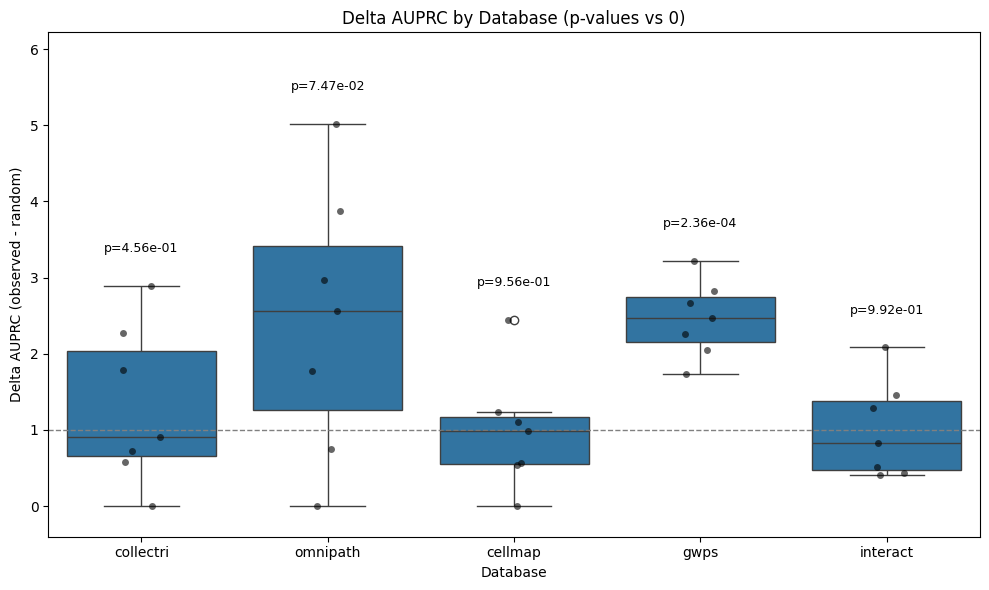

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(
    {i: v for i, v in show.items() if "_odd_ratio" in i},
    index=[
        "myeloid cell",
        "neoplastic cell",
        "oligodendrocyte precursor cell",
        "astrocyte",
        "oligodendrocyte",
        "vascular lymphangioblast",
        "neuron",
    ],
)

# Clean column names (remove '_auprc' suffix)
df.columns = [col.replace("_odd_ratio", "") for col in df.columns]

# Long format for seaborn
df_long = df.reset_index().melt(
    id_vars="index", var_name="Database", value_name="DeltaEPR"
)
df_long = df_long.rename(columns={"index": "Cell Type"})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x="Database", y="DeltaEPR")
sns.stripplot(data=df_long, x="Database", y="DeltaEPR", color="k", alpha=0.6, size=5)

# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long["DeltaEPR"].max()
min_y = df_long["DeltaEPR"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("Delta AUPRC by Database (p-values vs 0)")
plt.xlabel("Database")
plt.ylabel("Delta AUPRC (observed - random)")
plt.tight_layout()
plt.show()

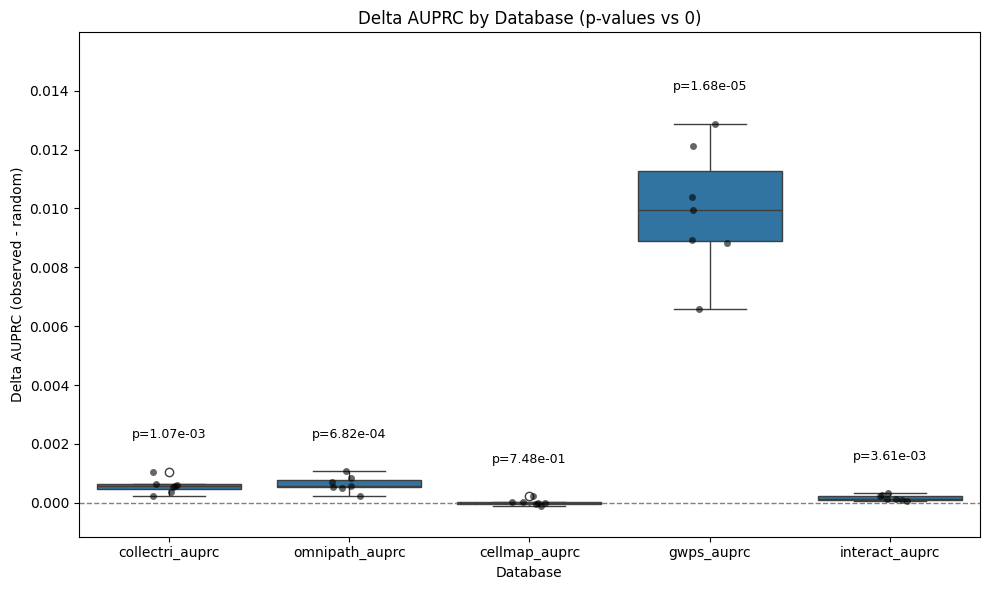

In [40]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_auprc" in i},
    index=[
        "myeloid cell",
        "neoplastic cell",
        "oligodendrocyte precursor cell",
        "astrocyte",
        "oligodendrocyte",
        "vascular lymphangioblast",
        "neuron",
    ],
)

# Long format for seaborn
df_long = df.reset_index().melt(
    id_vars="index", var_name="Database", value_name="DeltaAUPRC"
)
df_long = df_long.rename(columns={"index": "Cell Type"})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x="Database", y="DeltaAUPRC")
sns.stripplot(data=df_long, x="Database", y="DeltaAUPRC", color="k", alpha=0.6, size=5)

# Reference line at 0
ax.axhline(0, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long["DeltaAUPRC"].max()
min_y = df_long["DeltaAUPRC"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 0.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("Delta AUPRC by Database (p-values vs 0)")
plt.xlabel("Database")
plt.ylabel("Delta AUPRC (observed - random)")
plt.tight_layout()
plt.show()

In [ ]:
res = {
    "myeloid cell_collectri": {
        "precision": np.float64(0.0012939288856684437),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0012950935381307914),
        "auprc": np.float64(0.0023515517610108233),
        "ap": np.float64(0.0023844819820559074),
        "epr": np.float64(2.89554375),
        "odd_ratio": np.float64(2.90984069810094),
    },
    "myeloid cell_omnipath": {
        "precision": np.float64(0.001172037663315405),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0011725997916910958),
        "auprc": np.float64(0.0022395127762862644),
        "ap": np.float64(0.0022532868600549628),
        "epr": np.float64(5.016505190311419),
        "odd_ratio": np.float64(5.064178425125171),
    },
    "myeloid cell_cellmap": {
        "precision": np.float64(0.0010859056694979628),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0010862432217732187),
        "auprc": np.float64(0.0009862116680630318),
        "ap": np.float64(0.0009905605182477688),
        "epr": np.float64(1.4635995763836407),
        "odd_ratio": np.float64(1.4650771836585663),
    },
    "myeloid cell_gwps": {
        "precision": np.float64(0.01924866716228692),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.019262338090669226),
        "auprc": np.float64(0.019575465063865025),
        "ap": np.float64(0.01957960627987488),
        "epr": np.float64(0.7449586254559185),
        "odd_ratio": np.float64(0.7374785012899354),
    },
    "myeloid cell_interact": {
        "precision": np.float64(0.002134992600856161),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0021356562603528522),
        "auprc": np.float64(0.0019357570056030208),
        "ap": np.float64(0.0019365973966491191),
        "epr": np.float64(0.263648731079052),
        "odd_ratio": np.float64(0.2628188057925015),
    },
    "neoplastic cell_collectri": {
        "precision": np.float64(0.0012484305900271758),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0012494832296477722),
        "auprc": np.float64(0.0018626793005657944),
        "ap": np.float64(0.001871824760264888),
        "epr": np.float64(0.9099839338401289),
        "odd_ratio": np.float64(0.9097788859198542),
    },
    "neoplastic cell_omnipath": {
        "precision": np.float64(0.0009930398980492108),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0009935317454479475),
        "auprc": np.float64(0.0018297395974075908),
        "ap": np.float64(0.0018293539972560986),
        "epr": np.float64(0.7451952358724537),
        "odd_ratio": np.float64(0.744817514223301),
    },
    "neoplastic cell_cellmap": {
        "precision": np.float64(0.0008424353775397419),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0008427099653420691),
        "auprc": np.float64(0.0008499064660402024),
        "ap": np.float64(0.0008553333295223293),
        "epr": np.float64(0.0),
        "odd_ratio": np.float64(0.0),
    },
    "neoplastic cell_gwps": {
        "precision": np.float64(0.020393799799474872),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.02041271798110704),
        "auprc": np.float64(0.021710048006931854),
        "ap": np.float64(0.021725440698375686),
        "epr": np.float64(0.7688131681474087),
        "odd_ratio": np.float64(0.7613824149807253),
    },
    "neoplastic cell_interact": {
        "precision": np.float64(0.00210688024308096),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0021075669706699693),
        "auprc": np.float64(0.001978167203000946),
        "ap": np.float64(0.0019790368813557987),
        "epr": np.float64(0.5973195322480535),
        "odd_ratio": np.float64(0.5963037529510695),
    },
    "oligodendrocyte precursor cell_collectri": {
        "precision": np.float64(0.0007999566792690611),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.000800681934644645),
        "auprc": np.float64(0.0011801322637740527),
        "ap": np.float64(0.0011842425909145283),
        "epr": np.float64(0.0),
        "odd_ratio": np.float64(0.0),
    },
    "oligodendrocyte precursor cell_omnipath": {
        "precision": np.float64(0.0008837263904831473),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0008841531053023086),
        "auprc": np.float64(0.001401430221101886),
        "ap": np.float64(0.001403251230396189),
        "epr": np.float64(0.29810907492311617),
        "odd_ratio": np.float64(0.29773892810023933),
    },
    "oligodendrocyte precursor cell_cellmap": {
        "precision": np.float64(0.0009974558562653485),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0009977700155901566),
        "auprc": np.float64(0.0010460979359855132),
        "ap": np.float64(0.001050188297061808),
        "epr": np.float64(1.5858148233456175),
        "odd_ratio": np.float64(1.5876730769713758),
    },
    "oligodendrocyte precursor cell_gwps": {
        "precision": np.float64(0.02412672286232065),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.02414307996256629),
        "auprc": np.float64(0.02561487775620738),
        "ap": np.float64(0.025623913632011476),
        "epr": np.float64(0.26259282076753143),
        "odd_ratio": np.float64(0.2531531199188836),
    },
    "oligodendrocyte precursor cell_interact": {
        "precision": np.float64(0.0023138570492112617),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.002314585823085029),
        "auprc": np.float64(0.0020705370150649292),
        "ap": np.float64(0.0020712522976204365),
        "epr": np.float64(0.5963956054735742),
        "odd_ratio": np.float64(0.5952790158539915),
    },
    "astrocyte_collectri": {
        "precision": np.float64(0.0012086537903041195),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0012097718789167967),
        "auprc": np.float64(0.0017712577176512622),
        "ap": np.float64(0.0017748403969035044),
        "epr": np.float64(0.584171109640525),
        "odd_ratio": np.float64(0.5835827419880804),
    },
    "astrocyte_omnipath": {
        "precision": np.float64(0.0011736712436501377),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0011742256466939025),
        "auprc": np.float64(0.001724479503862171),
        "ap": np.float64(0.0017282601250631652),
        "epr": np.float64(1.7792736530818203),
        "odd_ratio": np.float64(1.7825401104659833),
    },
    "astrocyte_cellmap": {
        "precision": np.float64(0.001168891730052407),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0011692546272054813),
        "auprc": np.float64(0.0010607252973667356),
        "ap": np.float64(0.0010632132222821297),
        "epr": np.float64(0.0),
        "odd_ratio": np.float64(0.0),
    },
    "astrocyte_gwps": {
        "precision": np.float64(0.02247047030007282),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.02248255769668394),
        "auprc": np.float64(0.021644542498923815),
        "ap": np.float64(0.021654449556776506),
        "epr": np.float64(0.6879486953871813),
        "odd_ratio": np.float64(0.6780671370604341),
    },
    "astrocyte_interact": {
        "precision": np.float64(0.002699798114939706),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.002700636301252944),
        "auprc": np.float64(0.0023940429988216047),
        "ap": np.float64(0.002394570862060176),
        "epr": np.float64(0.1129108619834133),
        "odd_ratio": np.float64(0.11236961216783457),
    },
    "oligodendrocyte_collectri": {
        "precision": np.float64(0.0010782273400876292),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.001079220182942222),
        "auprc": np.float64(0.0016053846642866815),
        "ap": np.float64(0.0016126354082940145),
        "epr": np.float64(0.7273115984710512),
        "odd_ratio": np.float64(0.7268830116585386),
    },
    "oligodendrocyte_omnipath": {
        "precision": np.float64(0.0012039870701749792),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0012045695506153154),
        "auprc": np.float64(0.001764220680357672),
        "ap": np.float64(0.0017635801276010576),
        "epr": np.float64(3.869514417154577),
        "odd_ratio": np.float64(3.8964527971445566),
    },
    "oligodendrocyte_cellmap": {
        "precision": np.float64(0.0011463225748940035),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0011466771442026622),
        "auprc": np.float64(0.0010863329000135916),
        "ap": np.float64(0.0010958525360977422),
        "epr": np.float64(0.5298208108614868),
        "odd_ratio": np.float64(0.5292489906782089),
    },
    "oligodendrocyte_gwps": {
        "precision": np.float64(0.02060871518418688),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.020618404283944375),
        "auprc": np.float64(0.019278590744106042),
        "ap": np.float64(0.019282118871956546),
        "epr": np.float64(0.4683336881399644),
        "odd_ratio": np.float64(0.457915174129996),
    },
    "oligodendrocyte_interact": {
        "precision": np.float64(0.0029823418491769266),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0029832643180445965),
        "auprc": np.float64(0.00253112377738532),
        "ap": np.float64(0.0025320969368221253),
        "epr": np.float64(0.15050660114814843),
        "odd_ratio": np.float64(0.14974324033700703),
    },
    "vascular lymphangioblast_collectri": {
        "precision": np.float64(0.001036421062989736),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.001037250199840128),
        "auprc": np.float64(0.001686031314935142),
        "ap": np.float64(0.0017021448560088782),
        "epr": np.float64(1.7831458931674675),
        "odd_ratio": np.float64(1.786050914079677),
    },
    "vascular lymphangioblast_omnipath": {
        "precision": np.float64(0.0011211510312293981),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0011216705636813117),
        "auprc": np.float64(0.0018321503560471228),
        "ap": np.float64(0.0018434100991425605),
        "epr": np.float64(2.729513549740772),
        "odd_ratio": np.float64(2.740152593012846),
    },
    "vascular lymphangioblast_cellmap": {
        "precision": np.float64(0.0010523466108129124),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0010526744446480566),
        "auprc": np.float64(0.000986851620672997),
        "ap": np.float64(0.0009998185966248495),
        "epr": np.float64(1.2249662350489543),
        "odd_ratio": np.float64(1.225547542907584),
    },
    "vascular lymphangioblast_gwps": {
        "precision": np.float64(0.02047742546942644),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.020488536389377296),
        "auprc": np.float64(0.019696001529184035),
        "ap": np.float64(0.01970139335523981),
        "epr": np.float64(0.5012661455937587),
        "odd_ratio": np.float64(0.4908619387801331),
    },
    "vascular lymphangioblast_interact": {
        "precision": np.float64(0.00256320685989992),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0025640053667098576),
        "auprc": np.float64(0.002262506548224857),
        "ap": np.float64(0.0022631277435659586),
        "epr": np.float64(0.3319869585320239),
        "odd_ratio": np.float64(0.330848257580146),
    },
    "neuron_collectri": {
        "precision": np.float64(0.000612997256515775),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0006135653726015172),
        "auprc": np.float64(0.0008426809440857284),
        "ap": np.float64(0.0008527235162457846),
        "epr": np.float64(2.2794659885568977),
        "odd_ratio": np.float64(2.283052436660939),
    },
    "neuron_omnipath": {
        "precision": np.float64(0.000830826437853272),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0008312230137185957),
        "auprc": np.float64(0.0010760844436603764),
        "ap": np.float64(0.001082207873430046),
        "epr": np.float64(2.9664162131732033),
        "odd_ratio": np.float64(2.9761495935582434),
    },
    "neuron_cellmap": {
        "precision": np.float64(0.0011074245786732878),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0011077702168064568),
        "auprc": np.float64(0.0010395947808057697),
        "ap": np.float64(0.0010425299432658807),
        "epr": np.float64(0.0),
        "odd_ratio": np.float64(0.0),
    },
    "neuron_gwps": {
        "precision": np.float64(0.02122002269575085),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.021232155355954255),
        "auprc": np.float64(0.022024110077434995),
        "ap": np.float64(0.02201393489493468),
        "epr": np.float64(1.8145758598852293),
        "odd_ratio": np.float64(1.8811658789854417),
    },
    "neuron_interact": {
        "precision": np.float64(0.0024417515162144946),
        "recall": np.float64(1.0),
        "rand_precision": np.float64(0.0024425136109448987),
        "auprc": np.float64(0.0021729721527092155),
        "ap": np.float64(0.0021738706251222084),
        "epr": np.float64(0.735208326443446),
        "odd_ratio": np.float64(0.734254755987226),
    },
}